### Aleksandr Belov

# Home Assignment No. 2: Part 2 (Practice)
To solve this task, you will write a lot of code to try several machine learning methods for classification and regression.
* You are **HIGHLY RECOMMENDED** to read relevant documentation, e.g. for [python](https://docs.python.org/3/), [numpy](https://docs.scipy.org/doc/numpy/reference/), [matlpotlib](https://matplotlib.org/) and [sklearn](https://scikit-learn.org/stable/). Also remember that seminars, lecture slides, [Google](http://google.com) and [StackOverflow](https://stackoverflow.com/) are your close friends during this course (and, probably, whole life?).

* If you want an easy life, you have to use **BUILT-IN METHODS** of `sklearn` library instead of writing tons of our yown code. There exists a class/method for almost everything you can imagine (related to this homework).

* To do this part of homework, you have to write **CODE** directly inside specified places inside notebook **CELLS**.

* In some problems you may be asked to provide short discussion of the results. In this cases you have to create **MARKDOWN** cell with your comments right after the your code cell.

* For every separate problem you can get only 0 points or maximal points for this problem. There are **NO INTERMEDIATE scores**. So make sure that you did everything required in the task

* Your **SOLUTION** notebook **MUST BE REPRODUCIBLE**, i.e. if the reviewer decides to execute `Kernel` -> `Restart Kernel and Run All Cells`, after all the computation he will obtain exactly the same solution (with all the corresponding plots) as in your uploaded notebook. For this purpose, we suggest to fix random `seed` or (better) define `random_state=` inside every algorithm that uses some pseudorandomness.

* Your code must be clear to the reviewer. For this purpose, try to include neccessary comments inside the code. But remember: **GOOD CODE MUST BE SELF-EXPLANATORY** without any additional comments.

Before the start, read several additional recommendations.
* Probably you lauch `jupyter notebook` or `ipython notebook` from linux console. Try `jupyter lab` instead - it is a more convenient environment to work with notebooks.
* Probably the PC on which you are going to evaluate models has limited CPU/RAM Memory. In this case, we recommend to monitor the CPU and Memory Usage. To do this, you can execute `htop` (for CPU/RAM) or `free -s 0.2` (for RAM) in terminal.
* Probably tou have multiple Cores (CPU) on your PC. Many `sklearn` algorithms support multithreading (Ensemble Methods, Cross-Validation, etc.). Check if the particular algorithm has `n_jobs` parameters and set it to `-1` to use all the cores.

In [1]:
RANDOM_SEED = 42

import numpy as np
np.random.seed(RANDOM_SEED)

## Task 1. Deep ANNs. (5 points)

### Task 1.1.  Activation functions. (1 point)


Plot the following [activation functions](https://pytorch.org/docs/master/nn.html#non-linear-activation-functions) using their PyTorch realizations and their derivatives using autograd functionality `grad()`:
   
1. **(1 pt.)** Plot `ReLU`, `ELU` ($\alpha = 1$), `Softplus` ($\beta = 1$) and `Sign`, `Sigmoid`, `Softsign`, `Tanh`.
Which of these functions may be, and which - definitely, are a poor choise as an activation function in a neural network? Why?

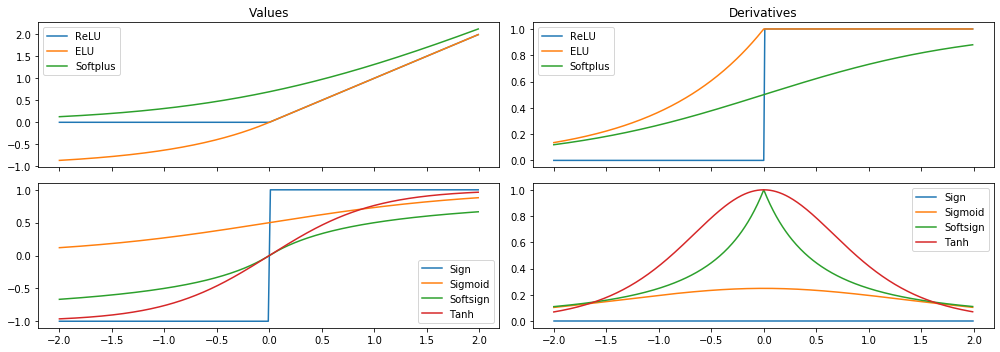

In [2]:
%matplotlib inline
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch

x = torch.arange(-2, 2, .01, requires_grad=True)
x_np = x.detach().numpy()
#x.sum().backward() # to create x.grad

f, axes = plt.subplots(2, 2, sharex=True, figsize=(14, 5))
axes[0, 0].set_title('Values')
axes[0, 1].set_title('Derivatives')

for i, function_set in (0, (('ReLU', F.relu), ('ELU', F.elu), ('Softplus', F.softplus))), \
                       (1, (('Sign', torch.sign), ('Sigmoid', torch.sigmoid), ('Softsign', F.softsign), 
                            ('Tanh', torch.tanh))):
    
    for function_name, activation in function_set:
        ### BEGIN Solution
        y = activation(x)
        y.sum().backward()

        axes[i, 0].plot(x_np, y.data, label=function_name)
        axes[i, 1].plot(x_np, x.grad.data, label=function_name)

        x.grad.zero_()
        ### END Solution

    axes[i, 0].legend()
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

### Task 1.2. MNIST classification. (4 points)

At the **Seminar 10** on neural networks, we built an MLP (Multilayer perceptron) with one hidden layer using our numpy implementations of linear layer and logistic and softmax activation functions. Your task is to

1. **(1 pt.)** Implement the MPL modules, including the Softmax cross entropy between `logits` and `labels`.
2. **(2 pt.)** Train our numpy realization of MLP to classify the MNIST from `sklearn.datasets()`. Getting accuracy on validation `> 90%`.
3. **(1 pt.)** Compare the acccuracy of classification to your scores from `Part 1` with and without dimensionality reduction. Will be this comparison fair? :) Derive the confusion matrix for all digits classes. What digits were predicted better or worse, than others?


In [3]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.datasets import load_digits

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
# fetch the dataset.
digits, targets = load_digits(return_X_y=True)
digits = digits.astype(np.float32) / 255

digits_train, digits_test, targets_train, targets_test = train_test_split(digits, targets, random_state=0)

train_size = digits_train.shape[0]

input_size = 8*8
classes_n = 10

**Implement the MLP with backprop.**

In [5]:
class Linear:
    def __init__(self, input_size, output_size):
        self.thetas = np.random.randn(input_size, output_size)
        self.thetas_grads = np.empty_like(self.thetas)
        self.bias = np.random.randn(output_size)
        self.bias_grads = np.empty_like(self.bias)

    def forward(self, x): 
        output = np.matmul(x, self.thetas) + self.bias
        return output

    def backward(self, x, output_grad):
        ### BEGIN Solution
        # ... calculate grads
        # >>> your solution here <<<
        self.thetas_grads = x.T @ output_grad
        self.bias_grads = output_grad.sum(axis=0)

        input_grad = output_grad @ self.thetas.T

        ### END Solution
        return input_grad


class LogisticActivation:
    def forward(self, x):
        output = 1/(1 + np.exp(-x))
        return output


    def backward(self, x, output_grad):
        ### BEGIN Solution
        # >>> your solution here <<<
        sigmoid = self.forward(x)
        input_grad = sigmoid * (1 - sigmoid) * output_grad

        ### END Solution
        return input_grad


class MLP:
    def __init__(self, input_size, hidden_layer_size, output_size):
        self.linear1 = Linear(input_size, hidden_layer_size)
        self.activation1 = LogisticActivation()
        self.linear2 = Linear(hidden_layer_size, output_size)
    
    def forward(self, x):
        return self.linear2.forward(self.activation1.forward(self.linear1.forward(x)))

    def backward(self, x, output_grad):
        ### BEGIN Solution
        # >>> your solution here <<<
        input_1 = x
        input_2 = self.linear1.forward(input_1)
        input_3 = self.activation1.forward(input_2)
        input_4 = self.linear2.forward(input_3)

        output_grad = self.linear2.backward(input_3, output_grad)
        output_grad = self.activation1.backward(input_2, output_grad)
        output_grad = self.linear1.backward(input_1, output_grad)

        return output_grad
        ### END Solution

In [6]:
### BEGIN Solution
def softmax_crossentropy_with_logits(logits, reference_answers):
    # >>> your solution here <<<
    correct_logits_idx = (range(logits.shape[0]), reference_answers)
    correct_logits = logits[correct_logits_idx]
    
    crossentropy = np.log(np.exp(logits).sum(axis=1)) - correct_logits

    return np.mean(crossentropy)


def softmax_with_logits(logits):
    return np.exp(logits) / np.exp(logits).sum(axis=1)[:, np.newaxis]


def grad_softmax_crossentropy_with_logits(logits, reference_answers):
    # >>> your solution here <<<
    m = logits.shape[0]
    correct_logits_idx = (range(logits.shape[0]), reference_answers)

    softmax = softmax_with_logits(logits)
    softmax[correct_logits_idx] -= 1

    return softmax / m
### END Solution

In [7]:
%%time
np.random.seed(42)

mlp = MLP(input_size=input_size, hidden_layer_size=100, output_size=classes_n)

epochs_n = 100
learning_curve = [0] * epochs_n
test_curve = [0] * epochs_n

x_train = digits_train
x_test = digits_test
y_train = targets_train
y_test = targets_test

learning_rate = 1e-2

for epoch in range(epochs_n):
    for sample_i in range(train_size):
        x = x_train[sample_i].reshape((1, -1))
        target = np.array([y_train[sample_i]])

        ### BEGIN Solution
        # ... zero the gradients -- change += to =
        
        # >>> your solution here <<<
        mlp.linear1.thetas_grads = 0
        mlp.linear1.bias_grads = 0
        mlp.linear2.thetas_grads = 0
        mlp.linear2.bias_grads = 0

        # ... perform backward pass
        # ... update the weights simply with weight -= grad * learning_rate
        
        # >>> your solution here <<<
        logits = mlp.forward(x)
        loss_grad = grad_softmax_crossentropy_with_logits(logits, target)

        mlp.backward(x, loss_grad)
        
        mlp.linear1.thetas -= mlp.linear1.thetas_grads * learning_rate
        mlp.linear1.bias -= mlp.linear1.bias_grads * learning_rate
        mlp.linear2.thetas -= mlp.linear2.thetas_grads * learning_rate
        mlp.linear2.bias -= mlp.linear2.bias_grads * learning_rate

    logits = mlp.forward(x_train)
    learning_curve[epoch] = softmax_crossentropy_with_logits(logits, y_train)

    logits = mlp.forward(x_test)
    test_curve[epoch] = softmax_crossentropy_with_logits(logits, y_test)

    if epoch % 10 == 0:
        y_pred = logits.argmax(axis=1)
        acc = accuracy_score(y_test, y_pred)
        print('Starting epoch {}'.format(epoch),', Accuracy on test: ', acc)
        print()

    ### END Solution

Starting epoch 0 , Accuracy on test:  0.06666666666666667

Starting epoch 10 , Accuracy on test:  0.6488888888888888

Starting epoch 20 , Accuracy on test:  0.8066666666666666

Starting epoch 30 , Accuracy on test:  0.8711111111111111

Starting epoch 40 , Accuracy on test:  0.8888888888888888

Starting epoch 50 , Accuracy on test:  0.9044444444444445

Starting epoch 60 , Accuracy on test:  0.9244444444444444

Starting epoch 70 , Accuracy on test:  0.9311111111111111

Starting epoch 80 , Accuracy on test:  0.9311111111111111

Starting epoch 90 , Accuracy on test:  0.9333333333333333

CPU times: user 36.2 s, sys: 221 ms, total: 36.5 s
Wall time: 19.2 s


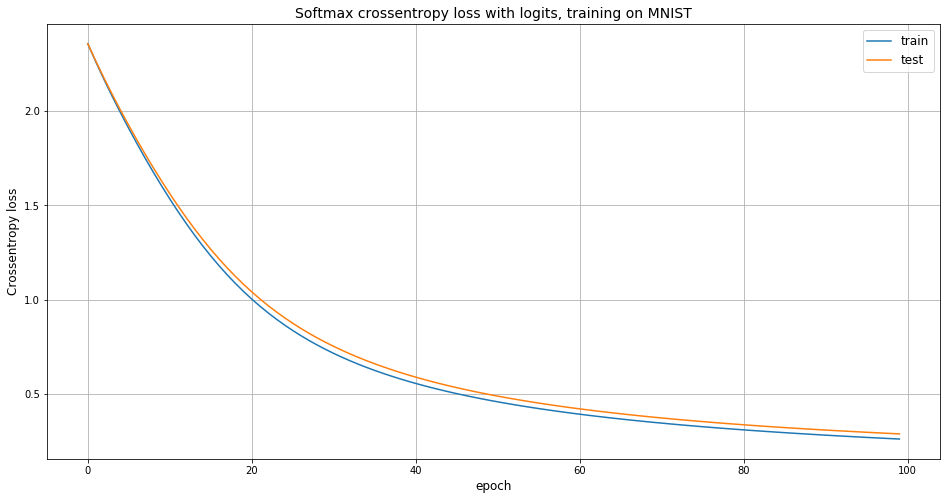

In [8]:
plt.figure(figsize=(16, 8))

plt.plot(learning_curve, label='train')
plt.plot(test_curve, label='test')

plt.legend(loc='best', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('Crossentropy loss', fontsize=12)
plt.title('Softmax crossentropy loss with logits, training on MNIST', fontsize=14)

plt.grid()
plt.show()

In [9]:
logits = mlp.forward(x_train)
y_pred = logits.argmax(axis=1)
train_cm = confusion_matrix(y_train, y_pred)

logits = mlp.forward(x_test)
y_pred = logits.argmax(axis=1)
test_cm = confusion_matrix(y_test, y_pred)

logits = mlp.forward(digits)
y_pred = logits.argmax(axis=1)
cm = confusion_matrix(targets, y_pred)

pd.DataFrame(cm, columns=range(10))

,0,1,2,3,4,5,6,7,8,9
0,176,0,0,0,1,1,0,0,0,0
1,0,166,2,0,0,0,2,0,3,9
2,0,3,171,2,0,0,0,1,0,0
3,0,0,0,178,0,1,0,2,1,1
4,0,0,0,0,175,0,0,4,1,1
5,0,0,0,0,1,174,1,0,0,6
6,1,2,0,0,1,0,177,0,0,0
7,0,0,0,0,0,0,0,177,1,1
8,0,16,2,2,0,4,1,3,144,2
9,0,2,0,8,2,3,0,4,3,158


Our MLP often give the `pred_y=8` for `true_y=1`, also the same for the `pred_y=1` and `true_y=9`.

## Task 2. Autoencoders. (7 points)

### Task 2.1.  Autoencoder on the tabular data. (3 points)


We will biuld the latent representation for tabular data with simple Autoencoding (AE) network. We will work with the cancer dataset from the scikit-learn package. You are to follow the instructions `1.0 - 1.6`.  

1. **(1 pt.)** Implement the AE modules;
2. **(2 pt.)** Train AE to get latent representation of the cancer dataset from `sklearn.datasets()`. Use `MSE` loss and get < $0.28$ on validation, with AE "bottleneck" = $2$;
3. **(1 pt.)** Plot the latent representation of whole dataset in 2D and use colors to show object of differneet classes;

In [10]:
# imports
import sklearn.datasets as sk_data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.utils.data as torch_data

#### 1.0 Featch the data. Scale it and split on train and test.

In [11]:
cancer_dset = sk_data.load_breast_cancer()

X = StandardScaler().fit_transform(cancer_dset['data'])

print('Features: ', list(cancer_dset['feature_names']))
print('\nShape:', X.shape)

X_train, X_val, y_train, y_val = train_test_split(X, cancer_dset['target'], 
                                                  test_size=0.2, random_state=RANDOM_SEED)
print('\nTrain size: ', len(X_train))
print('Validation size: ', len(X_val))

Features:  ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']

Shape: (569, 30)

Train size:  455
Validation size:  114


#### 1.1 Let us firtly make the dataset, which we'll be able to use with pytorch dataloader. 
Implement the `__len__` and `__getitem__` methods.

In [12]:
class CancerData(torch_data.Dataset):
    def __init__(self, X, y):
        super(CancerData, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        # >>> your solution here <<<
        return len(self.X)

    def __getitem__(self, idx):
        # >>> your solution here <<<
        return self.X[idx], self.y[idx]

In [13]:
train_dset = CancerData(X_train, y_train) 
val_dset = CancerData(X_val, y_val) 

print(len(train_dset))
print(train_dset[5])

455
(tensor([ 0.1172,  1.9199,  0.1961,  0.0111,  1.2482,  1.0453,  0.9429,  0.6376,
         1.7940,  1.1302, -0.1269, -0.3336,  0.0064, -0.1713, -0.4780,  0.9458,
         0.5145, -0.1454, -0.2388,  0.6321,  0.2466,  1.8650,  0.5016,  0.1101,
         1.5532,  2.5664,  2.0649,  0.8617,  2.1310,  2.7793]), tensor(0.))


#### 1.2 Now, we'll be making a base class for out autoencoder. 
It takes as input encoder and decoder (it will be tow neural networks). Using this two oblects, your task is to implement the forward pass.

In [14]:
class MyFirstAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(MyFirstAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        """
        Take a mini-batch as an input, encode it to the latent space and decode back to the original space
        x_out = decoder(encoder(x))
        :param x: torch.tensor, (MB, x_dim)
        :return: torch.tensor, (MB, x_dim)
        """
        # >>> your solution here <<<
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#### 1.3 It is time to create neural networks for encoder an decoder networks.
Make hidden size of the network to be equal to `2`.


**Hint.** You can use `nn.Sequential` to create your archtectures.

In [15]:
data_dim = X.shape[1]
print(data_dim)
torch.manual_seed(RANDOM_SEED)

encoder = lambda hidden_size: nn.Sequential(# >>> your solution here <<<
                                            nn.Linear(data_dim, 20),
                                            nn.BatchNorm1d(20),
                                            nn.ReLU(),
                                            #nn.Dropout(0.1),
    
                                            nn.Linear(20, 10),
                                            nn.BatchNorm1d(10),
                                            nn.ReLU(),
                                            #nn.Dropout(0.2),
    
                                            nn.Linear(10, hidden_size),
                                            #nn.BatchNorm1d(data_dim)
                                           )  

decoder = lambda hidden_size: nn.Sequential(# >>> your solution here <<<
                                            nn.Linear(hidden_size, 10),
                                            nn.BatchNorm1d(10),
                                            nn.ReLU(),
                                            #nn.Dropout(0.2),

                                            nn.Linear(10, 20),
                                            nn.BatchNorm1d(20),
                                            nn.ReLU(),
                                            nn.Dropout(0.2),

                                            nn.Linear(20, data_dim),
                                            #nn.BatchNorm1d(data_dim)
                                           )

30


In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # >>> your solution here <<<
torch.manual_seed(RANDOM_SEED)

net = MyFirstAE(encoder(2), decoder(2))
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.03, weight_decay=1e-6) # >>> your solution here <<<
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.99) # >>> your solution here <<<

train_loader = torch_data.DataLoader(train_dset, batch_size=300, shuffle=True) 
val_loader = torch_data.DataLoader(val_dset, batch_size=200, shuffle=False) 

#### 1.4 Implement the missing parts in the `train` function

In [17]:
def train(epochs, net, criterion, optimizer, train_loader, val_loader,
          scheduler=None, verbose=True, save_dir=None):

    net.to(device)
    for epoch in range(1, epochs+1):
        
        net.train()
        for X, _ in train_loader:
            # >>> your solution here <<<
            X = X.to(device)
            
            X_restored = net(X)
            loss = criterion(X, X_restored)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        # defining NN evaluation
        net.eval()
        for X, _ in val_loader:
            
            # >>> your solution here <<<
            X = X.to(device)

            X_restored = net(X)
            val_loss = criterion(X_restored, X)

        if scheduler is not None:
            scheduler.step()

        freq = max(epochs//20, 1)
        if verbose and epoch%freq == 0:
            print('Epoch {}/{} \t|| LR: {:.5f} | Loss:  Train {:.4f} | Validation {:.4f}'.format(epoch, epochs,
                                                                                  optimizer.param_groups[0]['lr'],
                                                                                  loss.item(), 
                                                                                  val_loss.item()))

#### 1.5 Train your AE on breast cancer dataset. 
Your goal is to get validation error < that 0.3.

Some feartures that mey help you to improve performance:
* `Dropout`
* `Batchnorm`
* lr scheduler (e.g. reduce learning)
* Batch size

In [18]:
%%time
# for `MSE` loss get < 0.28 on validation, with AE "bottleneck" = 2
train(100, net, criterion, optimizer, train_loader, val_loader, scheduler) 

Epoch 5/100 	|| LR: 0.02970 | Loss:  Train 0.7021 | Validation 0.5385
Epoch 10/100 	|| LR: 0.02940 | Loss:  Train 0.4407 | Validation 0.6599
Epoch 15/100 	|| LR: 0.02911 | Loss:  Train 0.4262 | Validation 0.5538
Epoch 20/100 	|| LR: 0.02882 | Loss:  Train 0.4036 | Validation 0.4445
Epoch 25/100 	|| LR: 0.02853 | Loss:  Train 0.3937 | Validation 0.3834
Epoch 30/100 	|| LR: 0.02824 | Loss:  Train 0.3600 | Validation 0.3491
Epoch 35/100 	|| LR: 0.02796 | Loss:  Train 0.3710 | Validation 0.3327
Epoch 40/100 	|| LR: 0.02768 | Loss:  Train 0.3728 | Validation 0.3408
Epoch 45/100 	|| LR: 0.02741 | Loss:  Train 0.4063 | Validation 0.3408
Epoch 50/100 	|| LR: 0.02713 | Loss:  Train 0.3823 | Validation 0.3310
Epoch 55/100 	|| LR: 0.02686 | Loss:  Train 0.3639 | Validation 0.3542
Epoch 60/100 	|| LR: 0.02659 | Loss:  Train 0.3812 | Validation 0.3389
Epoch 65/100 	|| LR: 0.02633 | Loss:  Train 0.3732 | Validation 0.3367
Epoch 70/100 	|| LR: 0.02606 | Loss:  Train 0.4129 | Validation 0.3273
Epoch 7

#### 1.6 Let's take a look at the latent space. 
Encode the whole dataset, using your AE, plot it in 2D and use colors to show object of differneet classes

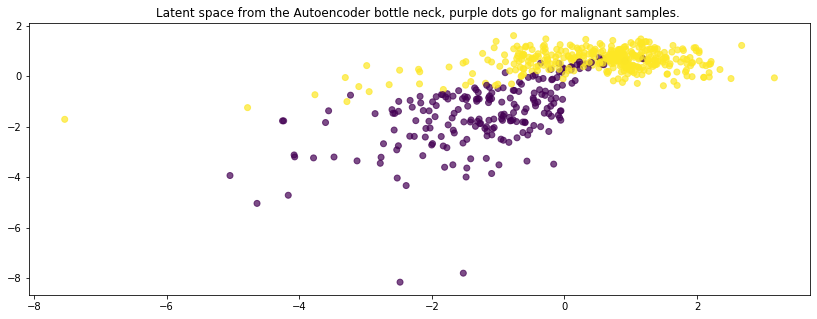

In [19]:
 ### BEGIN Solution
plt.figure(figsize=(14, 5))
net.eval()
enc = net.encoder(torch.tensor(X, dtype=torch.float32)).data
plt.scatter(enc[:,0], enc[:,1], c=cancer_dset['target'], alpha=0.7);
plt.title('Latent space from the Autoencoder bottle neck, purple dots go for malignant samples. ');
 ### END Solution

### Task 2.2.  Autoencoder on kMNIST. (4 points)


We will build the latent representation for `kMRIST` dataset, which you are already familiar with, using our AE network. We will work with the data from `Part 1`.

1. **(2 pt.)** Train AE to get latent representation of the `kMNIST` dataset from `sklearn.datasets()`. Follow the instructions `2.0 - 2.4`. Use `MSE` loss and get < $0.035$ on validation, with AE "bottleneck" < $40$;
2. **(1 pt.)** Plot 10 images and their reconstructions. Plot the latent representation of the whole dataset in 3D, compare visually to your manifold from `Part 1` and upload (pictures) screenshots to this notebook.
3. **(1 pt.)** Get the classification accuracy for the latest features. Use the `KNN` classifier with any hyperparameters you'll choose. Write a couple of sentences comparing the results of `manifold learning` and ` AE`. 
3. **(BONUS 3 pt.)** Sampling from latent representation.

In [20]:
def load(f):
    return np.load(f)['arr_0']

# Load the data
x_train = load('data/kmnist/kmnist-train-imgs.npz')
x_test = load('data/kmnist/kmnist-test-imgs.npz')
y_train = load('data/kmnist/kmnist-train-labels.npz')
y_test = load('data/kmnist/kmnist-test-labels.npz')


# Reshape the data and scale
x_train = x_train.reshape(-1, 1, 28, 28) / 255 # >>> your solution here <<<
x_test = x_test.reshape(-1, 1, 28, 28) / 255 # >>> your solution here <<<

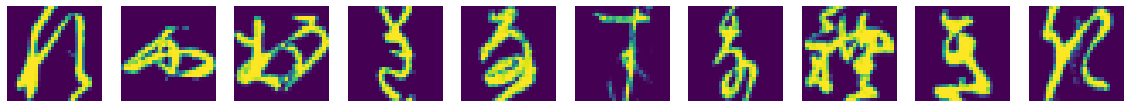

In [21]:
fig, ax = plt.subplots(ncols=10, figsize=(20, 5))
for i in range(10):
    ax[i].imshow(x_train[i][0]);
    ax[i].axis('off')

In [22]:
class kMNISTData(torch_data.Dataset):
    def __init__(self, X, y):
        super(kMNISTData, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)# >>> your solution here <<< 
        self.y = torch.tensor(y, dtype=torch.float32)# >>> your solution here <<<
    
    def __len__(self):
        # >>> your solution here <<<
        return len(self.X)

    def __getitem__(self, idx):
        # >>> your solution here <<<
        return self.X[idx], self.y[idx]    

In [23]:
train_kmnist = kMNISTData(x_train, y_train) ### YOUR CODE HERE ###
test_kmnist = kMNISTData(x_test, y_test) ### YOUR CODE HERE ###

#### 2.0 Create encoder and decoder network for kMNIST. 
You can either use convolutions or flatten the images and use linear layers. You can choose hidden size (not larger than 40) and any architecture you like.

In [24]:
data_dim = np.array(x_train.shape[-2:])
print(data_dim)
torch.manual_seed(RANDOM_SEED)

encoder = lambda hidden_size: nn.Sequential(# >>> your solution here <<<
                                            nn.Conv2d(1, 8, 3, stride=2, padding=1),
                                            nn.ReLU(),
                                            nn.Conv2d(8, 16, 3, stride=2, padding=1),
                                            nn.ReLU(),
                                            nn.Conv2d(16, hidden_size, 7)
                                           )

decoder = lambda hidden_size: nn.Sequential(# >>> your solution here <<<
                                            nn.ConvTranspose2d(hidden_size, 16, 7),
                                            nn.ReLU(),
                                            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
                                            nn.ReLU(),
                                            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
                                            nn.Sigmoid()
                                            )

[28 28]


#### 2.1 Train AE on the kMNIST. 
Your goal is to obtain MSE on the test set < $0.035$ on `MyFirstAE(encoder(40), decoder(40))`.

In [25]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # >>> your solution here <<<
torch.manual_seed(RANDOM_SEED)

hidden_size = 32
net = MyFirstAE(encoder(hidden_size), decoder(hidden_size))
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.03) # >>> your solution here <<<
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, 0.8) # >>> your solution here <<<

train_loader = torch_data.DataLoader(train_kmnist, batch_size=500, shuffle=True) 
val_loader = torch_data.DataLoader(test_kmnist, batch_size=500, shuffle=False) 

In [26]:
%%time

epochs = 100 # >>> your solution here <<<
train(epochs, net, criterion, optimizer, train_loader, val_loader, scheduler)

Epoch 5/100 	|| LR: 0.03000 | Loss:  Train 0.0318 | Validation 0.0361
Epoch 10/100 	|| LR: 0.03000 | Loss:  Train 0.0305 | Validation 0.0344
Epoch 15/100 	|| LR: 0.03000 | Loss:  Train 0.0287 | Validation 0.0341
Epoch 20/100 	|| LR: 0.02400 | Loss:  Train 0.0267 | Validation 0.0323
Epoch 25/100 	|| LR: 0.02400 | Loss:  Train 0.0268 | Validation 0.0315
Epoch 30/100 	|| LR: 0.02400 | Loss:  Train 0.0268 | Validation 0.0313
Epoch 35/100 	|| LR: 0.02400 | Loss:  Train 0.0281 | Validation 0.0317
Epoch 40/100 	|| LR: 0.01920 | Loss:  Train 0.0275 | Validation 0.0320
Epoch 45/100 	|| LR: 0.01920 | Loss:  Train 0.0270 | Validation 0.0310
Epoch 50/100 	|| LR: 0.01920 | Loss:  Train 0.0255 | Validation 0.0312
Epoch 55/100 	|| LR: 0.01920 | Loss:  Train 0.0269 | Validation 0.0309
Epoch 60/100 	|| LR: 0.01536 | Loss:  Train 0.0264 | Validation 0.0305
Epoch 65/100 	|| LR: 0.01536 | Loss:  Train 0.0265 | Validation 0.0305
Epoch 70/100 	|| LR: 0.01536 | Loss:  Train 0.0267 | Validation 0.0304
Epoch 7

#### 2.2 Plot any 10 images and their reconstructions.

/Users/aleksandr.belov/work/tools/anaconda3/envs/u_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


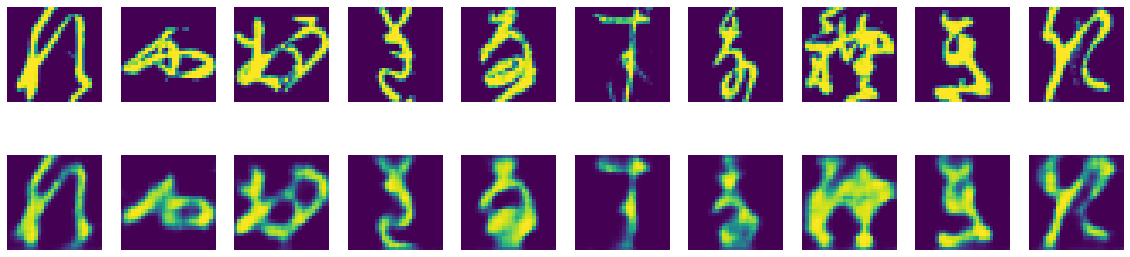

In [27]:
fig, ax = plt.subplots(ncols=10, nrows=2, figsize=(20, 5))

for i in range(10):
    im = train_kmnist[i][0].reshape(1, 1, 28, 28)
    rec = net(torch.tensor(im, dtype=torch.float32)).data # >>> your solution here <<<
    ax[0, i].imshow(im[0].reshape(28, 28))
    ax[1, i].imshow(rec.reshape(28, 28)) # >>> your solution here <<<
    ax[0, i].axis('off')
    ax[1, i].axis('off')

#### 2.3 Plot the latent representation of whole dataset in 3D, compare visually to your manifold from `Part 1` and upload (pictures) screenshoots to this notebook.

In [28]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # >>> your solution here <<<
torch.manual_seed(RANDOM_SEED)

net_3d = MyFirstAE(encoder(3), decoder(3))
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net_3d.parameters(), lr=0.03) # >>> your solution here <<<
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, 0.6) # >>> your solution here <<<

train_loader = torch_data.DataLoader(train_kmnist, batch_size=500, shuffle=True) 
val_loader = torch_data.DataLoader(test_kmnist, batch_size=500, shuffle=False) 

In [29]:
%%time

epochs = 100 # >>> your solution here <<<
train(epochs, net_3d, criterion, optimizer, train_loader, val_loader, scheduler)

Epoch 5/100 	|| LR: 0.03000 | Loss:  Train 0.0820 | Validation 0.0844
Epoch 10/100 	|| LR: 0.03000 | Loss:  Train 0.0815 | Validation 0.0838
Epoch 15/100 	|| LR: 0.03000 | Loss:  Train 0.0804 | Validation 0.0835
Epoch 20/100 	|| LR: 0.01800 | Loss:  Train 0.0787 | Validation 0.0837
Epoch 25/100 	|| LR: 0.01800 | Loss:  Train 0.0801 | Validation 0.0832
Epoch 30/100 	|| LR: 0.01800 | Loss:  Train 0.0809 | Validation 0.0832
Epoch 35/100 	|| LR: 0.01800 | Loss:  Train 0.0773 | Validation 0.0830
Epoch 40/100 	|| LR: 0.01080 | Loss:  Train 0.0778 | Validation 0.0830
Epoch 45/100 	|| LR: 0.01080 | Loss:  Train 0.0772 | Validation 0.0830
Epoch 50/100 	|| LR: 0.01080 | Loss:  Train 0.0799 | Validation 0.0832
Epoch 55/100 	|| LR: 0.01080 | Loss:  Train 0.0803 | Validation 0.0828
Epoch 60/100 	|| LR: 0.00648 | Loss:  Train 0.0795 | Validation 0.0828
Epoch 65/100 	|| LR: 0.00648 | Loss:  Train 0.0772 | Validation 0.0827
Epoch 70/100 	|| LR: 0.00648 | Loss:  Train 0.0780 | Validation 0.0827
Epoch 7

In [30]:
### BEGIN Solution

# >>> your solution here <<<
x_full = np.vstack((x_train, x_test))
x_full_tensor = torch.tensor(x_full, dtype=torch.float32)
print('Data shape:', x_full_tensor.shape)

latent_space_3d = net_3d.encoder(x_full_tensor)
latent_space_3d = latent_space_3d.reshape(len(x_full_tensor), 3).data
print('Latent space shape:', latent_space_3d.shape)

y_full = np.concatenate((y_train, y_test))

latent_space_3d_std = StandardScaler().fit_transform(latent_space_3d)

Data shape: torch.Size([70000, 1, 28, 28])
Latent space shape: torch.Size([70000, 3])


In [31]:
with open('kmnist_train_3.npy', 'rb') as f:
    kmnist_pca = np.load(f)
kmnist_pca_std = StandardScaler().fit_transform(kmnist_pca)

In [32]:
# The `plot_3d` function was here 

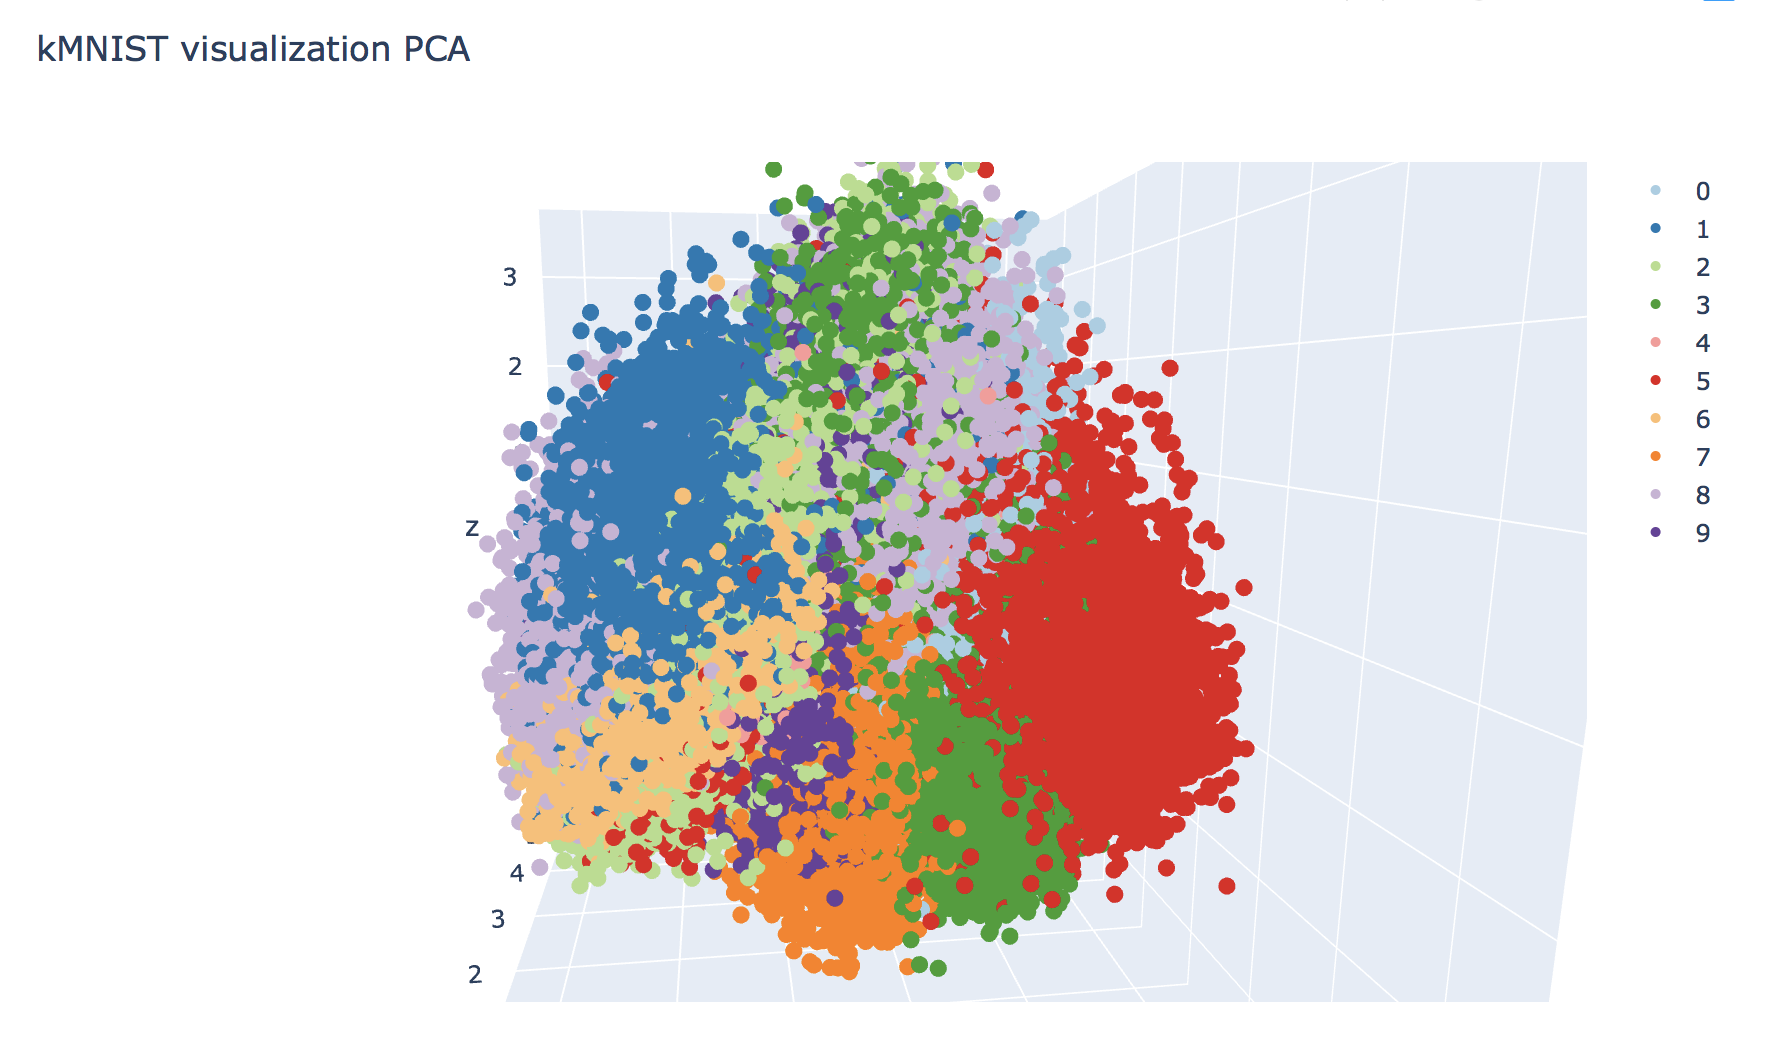

In [33]:
from IPython.display import Image
Image('kmnist_pca.png')

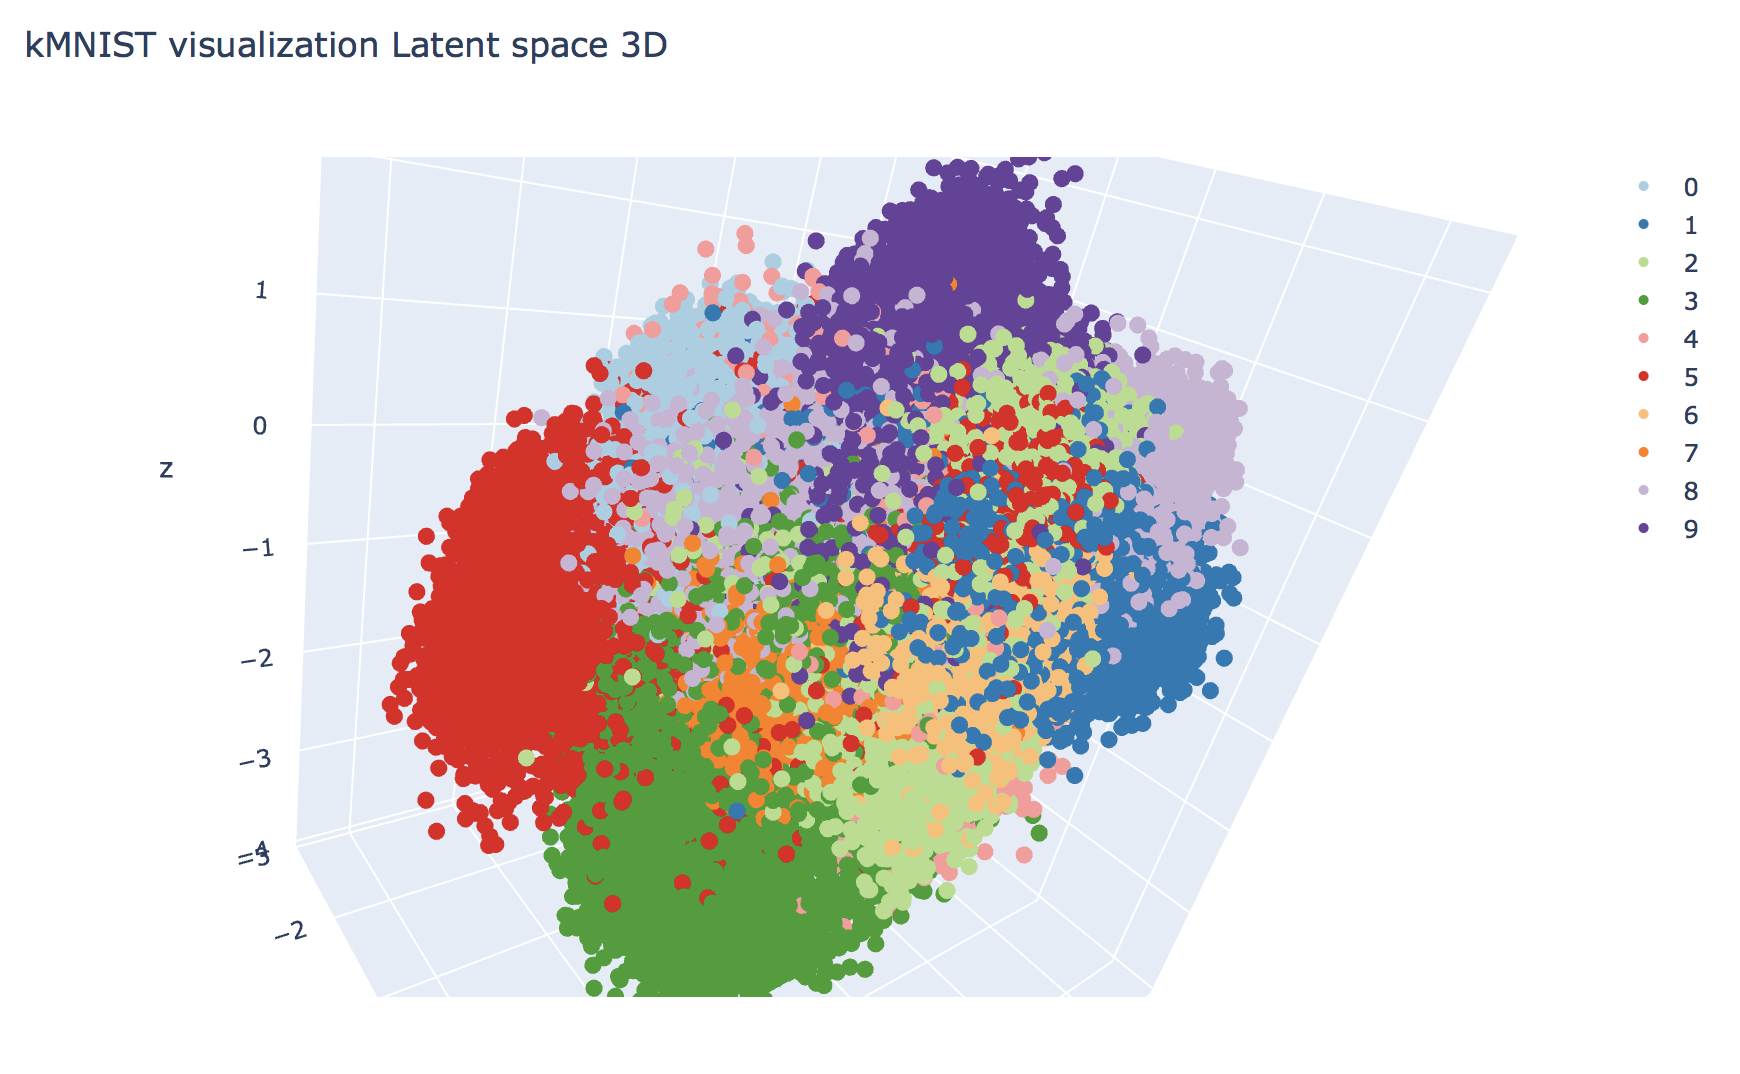

In [34]:
Image('latent_space_3d.png')

#### 2.4 Get the classification accuracy for the latest features. Use the `KNN` classifier with any hyperparameters you'll choose. Write a couple of sentences comparing the results of `manifold learning` and ` AE`. 

In [35]:
### BEGIN Solution

# >>> your solution here <<<

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

latent_train = net.encoder(x_train_tensor)
latent_train = latent_train.reshape(len(x_train_tensor), hidden_size).data

latent_test = net.encoder(x_test_tensor)
latent_test = latent_test.reshape(len(x_test_tensor), hidden_size).data

In [36]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(5, n_jobs=-1)
knn.fit(latent_train, y_train)

y_pred = knn.predict(latent_test)
print('The classification accuracy for the Latent space: ', accuracy_score(y_test, y_pred))

### END Solution

The classification accuracy for the Latent space:  0.9259


The classification accuracy for the PCA `n_components=32` is `0.9238`.

So, with the autoencoder we got the better result. It means that autoencoder able to better separate classes.

### BONUS: Sampling from latent space. (3 points)

Imagine, that you want to generate images, using you AE. To do that, you need to sample from the latent space and then decode the result. Of course, we do not know the exact distribution of the latent space. Therefore, let us assume that latent space is gaussian:

* Encode all the training images into the latent space
* Calculate mean and standart deviation ($\mu$ and $\sigma$)
* Sample  $z$ from the $\mathcal{N}(\mu, \sigma^2)$
* Decode z from the previous step to obtain the image

Usign the procedure, described above, sample 10 images and plot them (they should resamble the initial dataset)

In [37]:
latent_space = net.encoder(x_full_tensor)
latent_space = latent_space.reshape(len(x_full_tensor), hidden_size).data
print('Latent space shape:', latent_space_3d.shape)

ls_mean = latent_space.mean(axis=0)
ls_std = latent_space.std(axis=0)

Latent space shape: torch.Size([70000, 3])


In [38]:
np.random.seed(1)
num_images = 10

z = np.random.multivariate_normal(ls_mean, np.diag(ls_std), num_images)
z = z.reshape(num_images, hidden_size, 1, 1)

z_tensor = torch.tensor(z, dtype=torch.float32)

decoded_images = net.decoder(z_tensor).data
decoded_images.shape

torch.Size([10, 1, 28, 28])

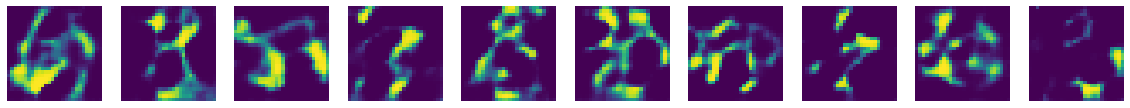

In [39]:
### BEGIN Solution

# >>> your solution here <<<
fig, ax = plt.subplots(ncols=num_images, nrows=1, figsize=(20, 5))
for i in range(num_images):
    im = decoded_images[i][0].reshape(1, 1, 28, 28)
    ax[i].imshow(im[0].reshape(28, 28))
    ax[i].axis('off')

### END Solution

**Yeah, so you can get more than `100%` for the homework, good luck!**